Дата начала 
 15/01
Дата окончания 
 28/01

In [22]:
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [23]:
def prepare_data(csv_filename, y_val_name, ds_val_name):
    d = pd.read_csv(csv_filename)
    d = d[d[y_val_name] != 0]
    d[ds_val_name] = pd.to_datetime(d[ds_val_name], 
                                    #dayfirst = True
                                   )
    d = d.rename(columns={y_val_name: "y", ds_val_name: "ds"})
    d = d[["ds", "y"]]
    return d

def set_holidays():
    # Setting holidays 

    black_fridays = pd.DataFrame({
      'holiday': 'black_friday',
      'ds': pd.to_datetime(['2022-11-26', '2022-11-25', '2023-11-24',]),
      'lower_window': -14,
      'upper_window': 14,
    })
    new_years = pd.DataFrame({
      'holiday': 'new_year',
      'ds': pd.to_datetime(['2021-12-31', '2022-12-31', '2023-12-31']),
      'lower_window': -2,
      'upper_window': 7,
    })
    febs_23 = pd.DataFrame({
      'holiday': '23_feb',
      'ds': pd.to_datetime(['2021-02-23', '2022-02-23', '2023-02-23']),
      'lower_window': -4,
      'upper_window': 3,
    })
    
    mays_1 = pd.DataFrame({
      'holiday': '1_may',
      'ds': pd.to_datetime(['2021-05-01', '2022-05-01', '2023-05-01']),
      'lower_window': -2,
      'upper_window': 2,
    })
    
    
    holidays = pd.concat((black_fridays, new_years, febs_23, mays_1))
    return holidays

In [28]:
d = prepare_data("data_for_metric_2.csv", "y", "dt")
d.head()

holidays = set_holidays()

In [29]:
test = d[d["ds"] >= "2024-01-15"]
train = test = d[d["ds"] < "2024-01-15"]

In [30]:
# Setting Baseline Prophet model
model = Prophet(yearly_seasonality=7, 
            weekly_seasonality=10, 
            holidays=holidays, 
            growth = "linear", 
            holidays_prior_scale = 10,
            n_changepoints = 20,
            seasonality_mode='multiplicative'
               )
model.fit(train)

21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Creating Future Dataset for Forecasting 
future = model.make_future_dataframe(periods=50)
future.tail()

,ds
758,2024-02-29
759,2024-03-01
760,2024-03-02
761,2024-03-03
762,2024-03-04


In [32]:
forecast = model.predict(future)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


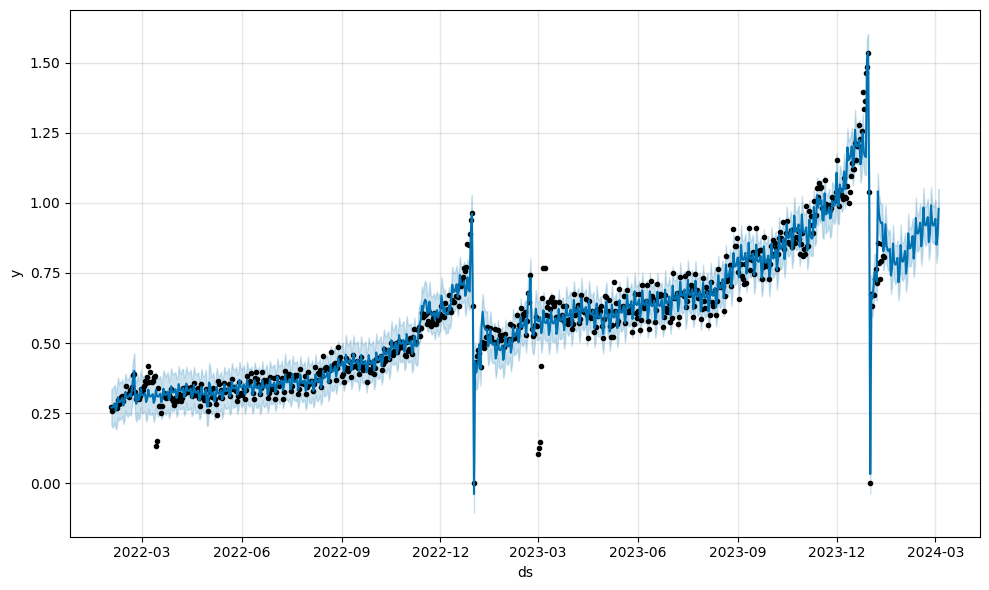

In [33]:
predict_plot = model.plot(forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

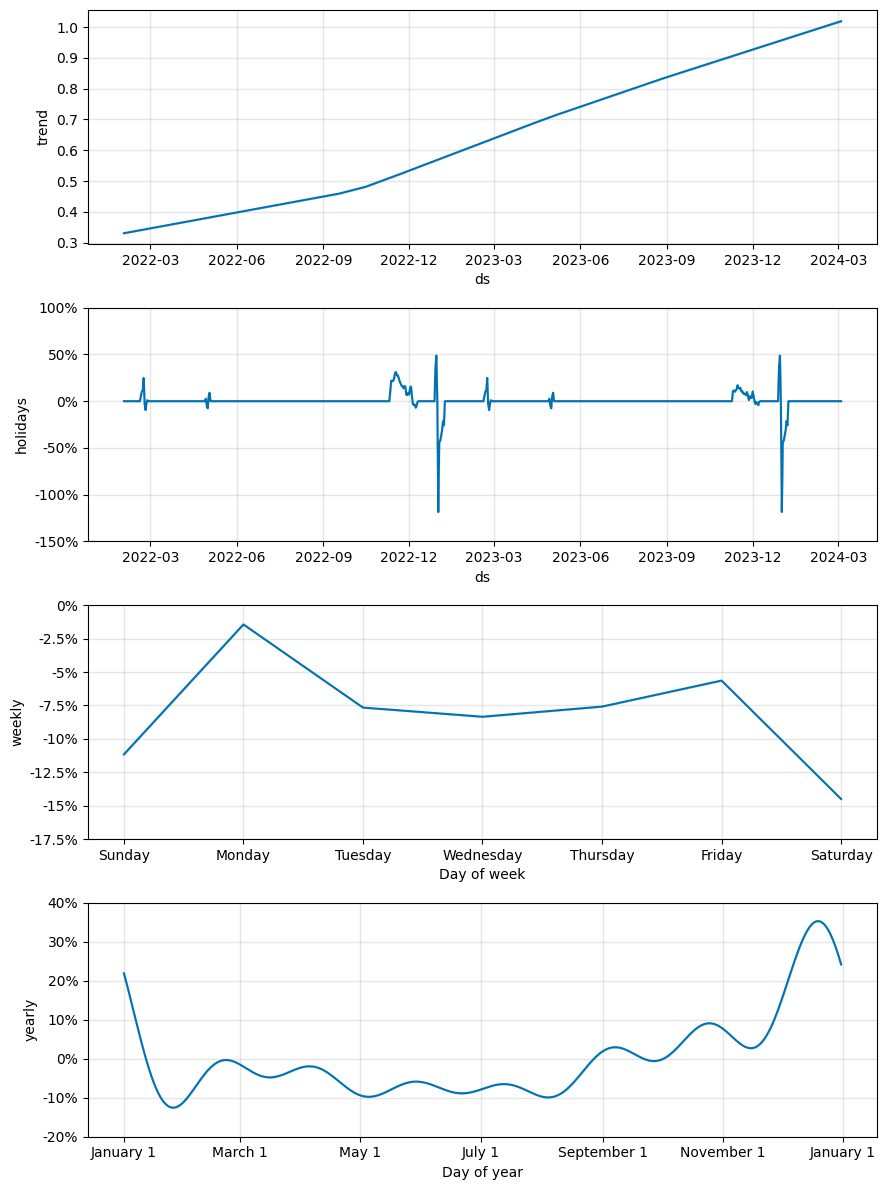

In [34]:
components_plot = model.plot_components(forecast)

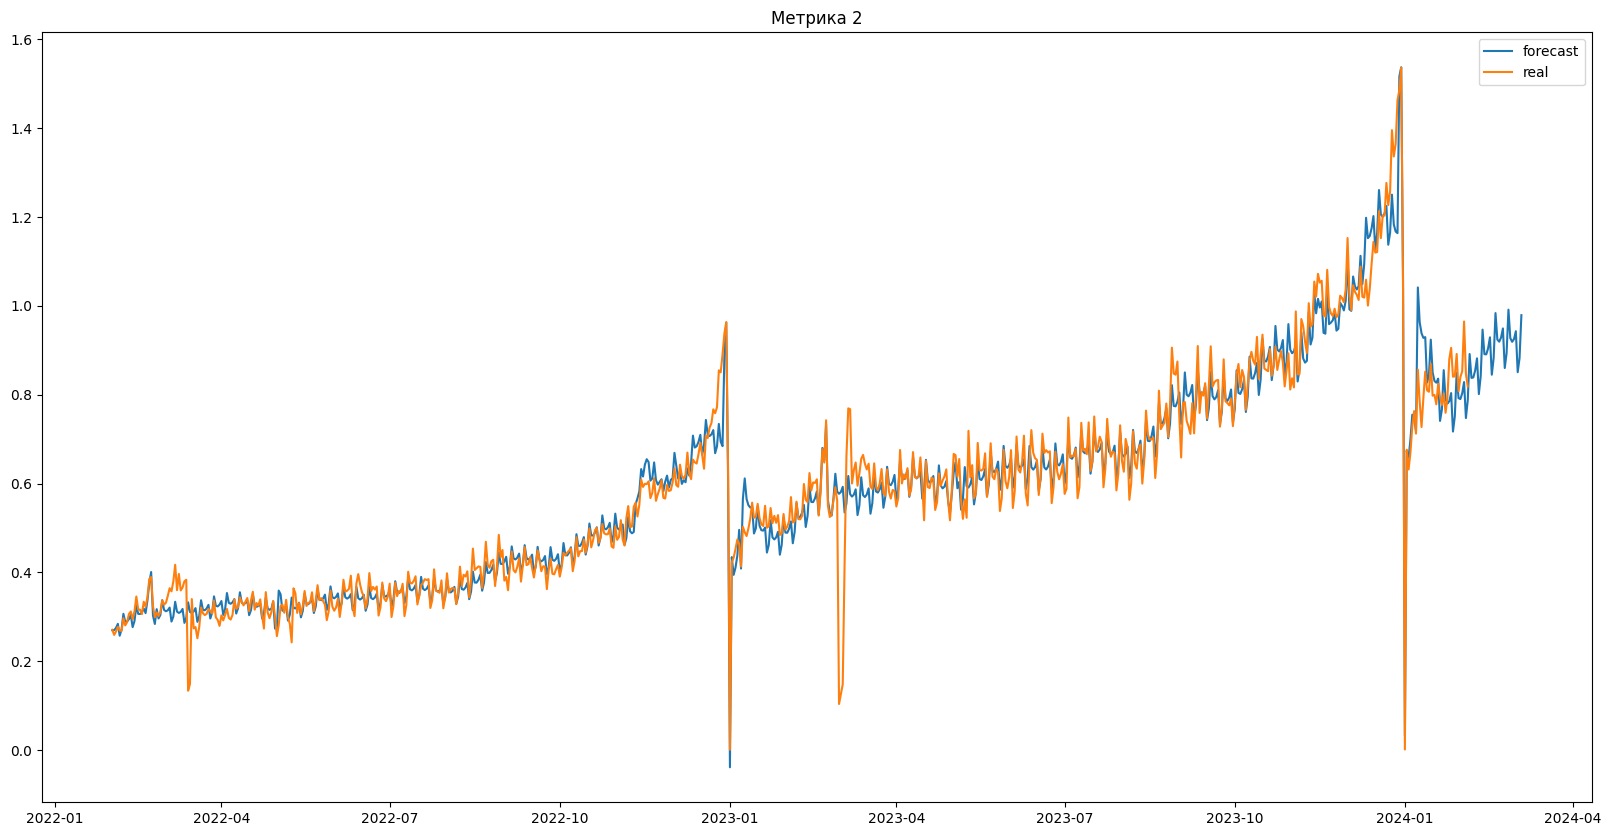

In [35]:
df = pd.merge(d, forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], how = "right", on = "ds")

plt.figure()
plt.plot(df.ds, df.yhat, label = "forecast", ls = "-")
plt.plot(df.ds, df.y, label = "real")
plt.title("Метрика 2")
plt.legend()
plt.show()

In [36]:
plot_only_test = df[df["ds"] <= "2024-01-28"].tail(50)

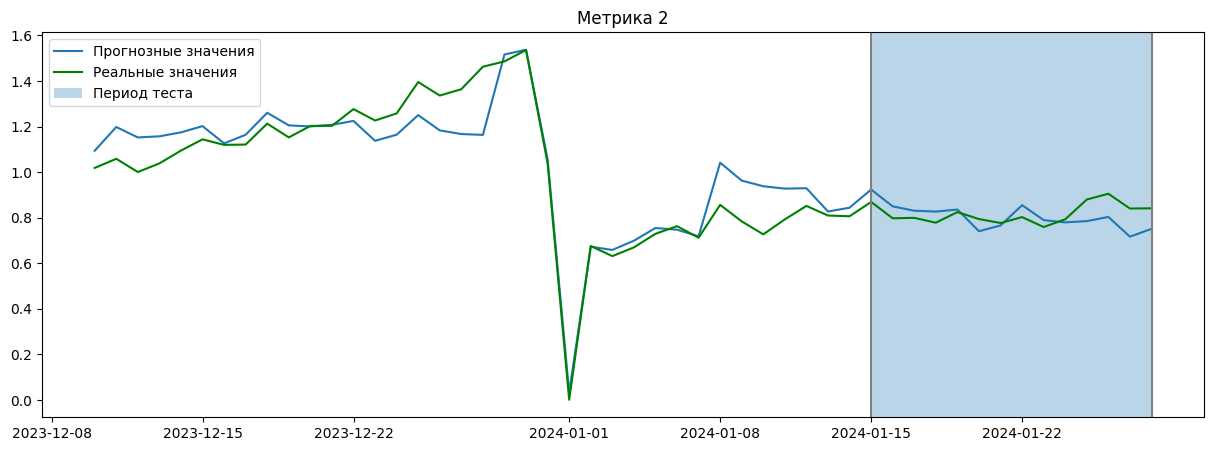

In [37]:
plt.rcParams["figure.figsize"] = (15,5)
import datetime as dt


plt.figure()
plt.plot(plot_only_test["ds"], plot_only_test["yhat"], label = "Прогнозные значения", ls = "-")
plt.plot(plot_only_test.ds, plot_only_test["y"], label = "Реальные значения", color = "green")
plt.axvline(dt.datetime(2024, 1, 15),  color = "grey")
plt.axvline(dt.datetime(2024, 1, 28),  color = "grey")
plt.axvspan(dt.datetime(2024, 1, 15), dt.datetime(2024, 1, 28), alpha = 0.3, label = "Период теста")
#plt.ylabel("млрд. руб.")
plt.title("Метрика 2")
plt.legend()
plt.savefig("metric_2.png")
plt.show()

In [38]:
prcnt_cnhg = (plot_only_test.mean()["yhat"] - plot_only_test.mean()["y"])/plot_only_test.mean()["y"]
prcnt_cnhg

0.011085095648166338

test period:
p val 0.4435
